# Predicting Rental Profit 

## 1. Introduction

### objective : create a web app that predicts most profitable rental investment properties on the market
This notebook demonstrates how to predict rental profit, with a subset of listings on zillow.com in the city of Philadelphia. The preliminary analysis of this small dataset showcases the feasibility of the project. The planned final product is a web application showing estimated rental profit for all active sales listing in several major cities on zillow.com, and make recommendations based on user's preference.

## 2. Packages

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

## 3. Data Collection

- Write the list of zipcode in Philly into a file as preparation for scraper

In [102]:
pwd

'/Users/yundijiang/Desktop/DataIncubator/2020/Zillow_data'

In [172]:
zip_list = []
with open('philly_zipcode','w') as f:
    for x in range(19102, 19155):
        zip_list.append(x)
        f.write(str(x)+'\n')

- Run scraper code to collect all data files
- Listings in each zipcode area are in one file

In [173]:
f_list = [line.rstrip('\n') for line in open('Data/file_list')]
f_list_rent = f_list[1:50]
f_list_sale = f_list[50:]

- Read sales data

In [258]:
df_from_each_file_sale = (pd.read_csv('Data/'+str(i)) for i in f_list_sale)
sale_data = pd.concat(df_from_each_file_sale, ignore_index=True)
sale_data.head(3)

,title,address,city,state,postal_code,price,bedroom,bathroom,area,lot_size,year_built,home_type,tax_assessed_value,url,long,lat
0,House for sale,50 S 16th St UNIT 4604,Philadelphia,PA,19102,"$11,500,000",2.0,4.0,5550.0,-1.0,2007,SINGLE_FAMILY,7800000.0,https://www.zillow.com/homedetails/50-S-16th-S...,-75.167249,39.951805
1,Condo for sale,111 S 15th St PENTHOUSE P310,Philadelphia,PA,19102,"$549,000",2.0,2.0,1062.0,-1.0,1900,CONDO,407600.0,https://www.zillow.com/homedetails/111-S-15th-...,-75.165495,39.950653
2,Condo for sale,111 S 15th St APT 1705,Philadelphia,PA,19102,"$287,000",1.0,1.0,798.0,-1.0,1900,CONDO,295100.0,https://www.zillow.com/homedetails/111-S-15th-...,-75.165495,39.950653


In [232]:
df_from_each_file_rent = (pd.read_csv('Data/'+str(i)) for i in f_list_rent)
rent_data = pd.concat(df_from_each_file_rent, ignore_index=True)
rent_data = rent_data.dropna(subset = ['price'])
rent_data.head(3)

,title,address,city,state,postal_code,price,bedroom,bathroom,area,year_built,lot_size,home_type,url,long,lat
0,Apartment for rent,326 S 16th St APT 1R,Philadelphia,PA,19102,"$1,692/mo",1.0,1.0,700.0,-1,-1.0,APARTMENT,https://www.zillow.com/homedetails/326-S-16th-...,-75.168405,39.946715
1,Apartment for rent,1518 Pine St APT 1R,Philadelphia,PA,19102,"$1,475/mo",1.0,1.0,500.0,1900,-1.0,APARTMENT,https://www.zillow.com/homedetails/1518-Pine-S...,-75.167590,39.945608
2,Apartment for rent,1414 S Penn Sq #18X,Philadelphia,PA,19102,"$7,995/mo",3.0,3.5,2046.0,-1,-1.0,APARTMENT,https://www.zillow.com/homedetails/1414-S-Penn...,-75.164920,39.951482


In [259]:
rent_data = rent_data[rent_data['state']=='PA']
sale_data= sale_data[sale_data['state']=='PA']

In [246]:
rent_data.shape, sale_data.shape

((1142, 15), (1864, 16))

## 4. Data Preprocessing


- Rental Listings are used for building a predictive model
- Rental listings that are off market are dropped
- Missing values in the features: bedroom, bathroom, area, and year are filled with median, and the missing lot_size is filled with area

In [109]:
rent_data_area = rent_data[~rent_data['area'].isnull()]

In [110]:
area = rent_data_area['area'].to_numpy().reshape(-1,1)
bed = rent_data_area['bedroom'].to_numpy()
bath = rent_data_area['bathroom'].to_numpy()
bath[np.isnan(bath)]= 0
bb = np.concatenate((bed.reshape(-1,1), bath.reshape(-1,1)),axis=1)


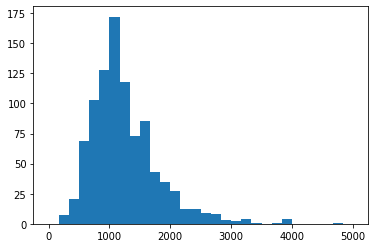

In [111]:
plt.hist(area,30,(0,5000))
plt.show()

Let's first check how many missing values there are in the dataset

### Impute Missing Data

- get rid of the 'Off market' listings
- number of bathrooms is imputed with 0
- There are ~15% area info missing, as we can intuitively think that how spacious the place is would be important to predicting the rent price, we need to impute this feature rationally instead of simply using mean or median
- I built a simple linear model to predict area based on number of bedroom and bathroom, and use this to estimate the area
- The year built has lots of '-1' entries, which is also essentially missing. I currently imputed this feature using the median, however, as a fine tuning step, I plan to impute this entry using the median of listings in the same zipcode area

In [112]:
rent_data = rent_data[~rent_data['title'].str.contains('Off market')]
rent_data['bathroom'] = rent_data['bathroom'].fillna(1)
rent_data['area'].fillna(513+160*rent_data['bedroom']+220*rent_data['bathroom'],inplace=True)
rent_data['lot_size'] = rent_data['lot_size'].fillna((rent_data['area']))
rent_select = rent_data[['bedroom', 'bathroom', 'area','postal_code','year_built','home_type','price']]

- zipcode and home type are one-hot encoded
- "drop_first" was turned on to avoid multicolineararity in among the features

In [113]:
rent_data.isnull().sum().sum()

0

In [114]:
zip_dummy = pd.get_dummies(rent_select['postal_code'],drop_first=True)
home_type_dummy = pd.get_dummies(rent_select['home_type'],drop_first=True)
X_rent = pd.concat([rent_select, zip_dummy, home_type_dummy], axis=1)
X_rent = X_rent.drop(columns = ['home_type','postal_code'])

- year built feature shows -1 when the data is missing from the website, this can introduce bias
- replace the -1 value with median (further improvement, impute with median based on zipcode)

In [115]:
median_year = np.median(X_rent['year_built'][X_rent['year_built']>-1])
X_rent['year_built'][X_rent['year_built']<0] = median_year

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [116]:
X_rent.head(3)

,bedroom,bathroom,area,year_built,price,19103,19104,19106,19107,19111,...,19149,19150,19151,19152,19153,19154,CONDO,MULTI_FAMILY,SINGLE_FAMILY,TOWNHOUSE
0,1.0,1.0,700.0,1929,"$1,692/mo",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,500.0,1900,"$1,475/mo",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,3.5,2046.0,1929,"$7,995/mo",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


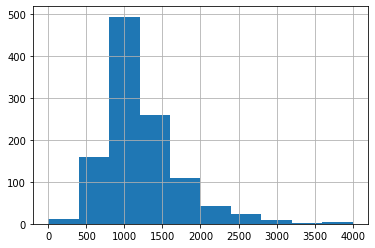

In [117]:
X_rent['area'].hist(range=(0,4000))

- Prepare the target variable,price

In [118]:
y_rent = X_rent['price'].apply(lambda x: int(x.strip('$+/mo').replace(',','')))
y_rent = y_rent.values
X_rent = X_rent.drop(columns = 'price')
X = X_rent.values
y = y_rent

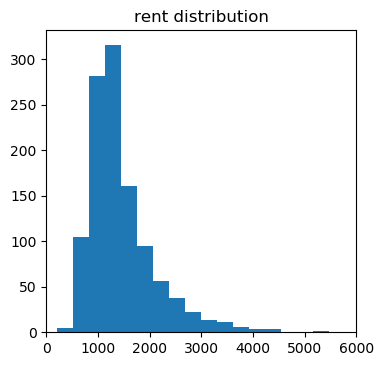

In [119]:
plt.figure(figsize=(4,4), dpi=100)
plt.hist(y_rent,30)
plt.xlim([0,6000])
plt.title('rent distribution')
plt.show()

- The target variable, rent, seems to be rather skewed 
- Machine learning models tend to have problems predicting non-normal distributions
- We therefore transform the target variable for better model performance
- We also get rid of outliers 

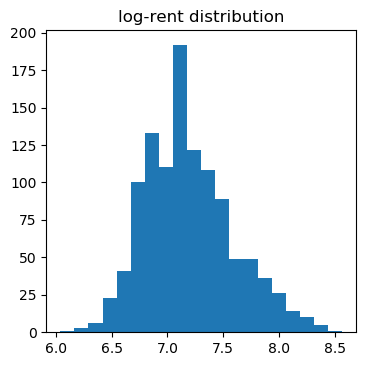

((array([-3.22960979, -2.96683164, -2.82034652, ...,  2.82034652,
          2.96683164,  3.22960979]),
  array([6.04025471, 6.2146081 , 6.2146081 , ..., 8.35467426, 8.37793112,
         8.56598336])),
 (0.38977215546905164, 7.190065818150888, 0.9916391109807006))

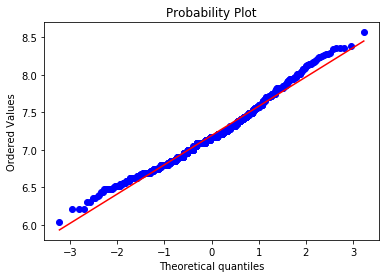

In [120]:
log_y_rent = np.log(y_rent)
mask = np.logical_and(log_y_rent >= 6 , log_y_rent <=8.9)
plt.figure(figsize=(4,4), dpi=100)
plt.hist(log_y_rent[mask],20)
#plt.xlim([0,6000])
plt.title('log-rent distribution')
plt.show()
fig = plt.figure()
stats.probplot(log_y_rent[mask], plot=plt)

- Split the data into train and test set for model building

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X[mask,:], log_y_rent[mask],test_size=0.2, random_state=42)

## 5. Modelling

### 5.1 Linear Models

In [122]:
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#### 5.1.1 Linear Regression

In [123]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred)))

In sample R^2 is 0.732876109740819
Out of sample R^2 is 0.6773201748702786


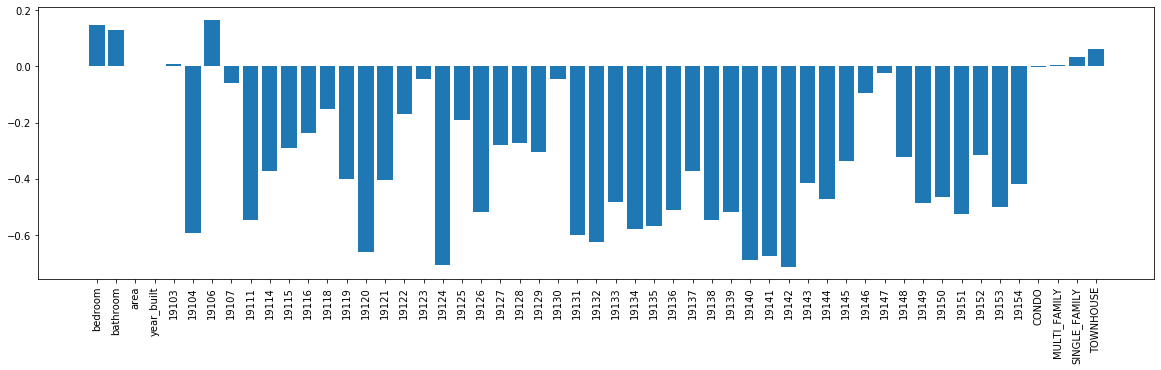

In [434]:
labels = X_rent.columns.to_list()
ticks = range(len(labels))
plt.figure(figsize=(20,5))
plt.bar(range(len(lm.coef_)),lm.coef_)
plt.xticks(ticks = ticks,labels = labels, rotation=90)
plt.show()

#### 5.1.2 Ridge Regression

In [125]:
for alpha in [1e-7, 1e-6, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1]:
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train, y_train)
    y_train_pred_ridge = ridge.predict(X_train)
    y_test_pred_ridge = ridge.predict(X_test)
    print('alpha', alpha, metrics.r2_score(y_test, y_test_pred_ridge))

alpha 1e-07 0.6773201741089439
alpha 1e-06 0.6773201672569433
alpha 1e-05 0.6773200987296715
alpha 0.0001 0.6773194127310525
alpha 0.001 0.6773124807085014
alpha 0.01 0.6772364838048506
alpha 0.1 0.6761500356551914
alpha 1 0.6702792814608292


In [126]:
ridge = Ridge(alpha = 1e-4)
ridge.fit(X_train, y_train)
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_ridge)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_ridge)))

In sample R^2 is 0.7328761081002593
Out of sample R^2 is 0.6773194127310525


In [418]:
from sklearn.metrics import mean_squared_error
print('MAE is ', abs(np.exp(y_test_pred_ridge)-np.exp(y_test)).mean())

MAE is  258.6007960623093


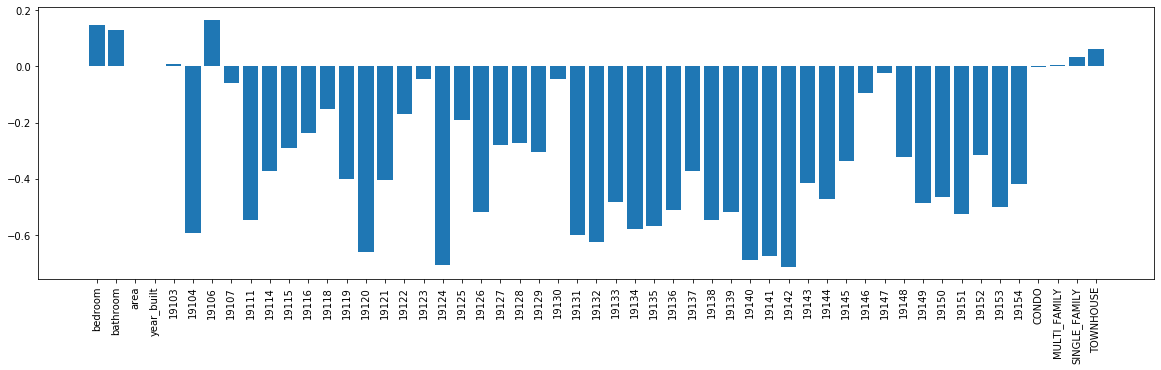

In [424]:
#labels = list(reversed(X_rent.columns.to_list()))
labels = X_rent.columns.to_list()
ticks = range(len(labels))
plt.figure(figsize=(20,5))
plt.bar(range(len(ridge.coef_)),ridge.coef_)
plt.xticks(ticks = ticks,labels = labels,rotation=90)
plt.show()

#### 5.1.2  LASSO Regression

In [128]:
for alpha in [1e-9,1e-8,1e-7, 1e-6,1e-5,1e-4, 1e-3, 0.01, 0.1, 1,10]:
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    y_train_pred_lasso = lasso.predict(X_train)
    y_test_pred_lasso = lasso.predict(X_test)
    print('alpha', alpha, metrics.r2_score(y_test, y_test_pred_lasso))

alpha 1e-09 0.6773201545646133
alpha 1e-08 0.6773199717680776
alpha 1e-07 0.677318139254229
alpha 1e-06 0.6772993595727638
alpha 1e-05 0.677068027831096
alpha 0.0001 0.6741287589650036
alpha 0.001 0.6602600064768498
alpha 0.01 0.4428049613889389
alpha 0.1 0.2667608627056669
alpha 1 0.12905245801193999
alpha 10 0.09982722589636606


In [129]:
lasso = Lasso(alpha=1e-4)
lasso.fit(X_train, y_train)
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_lasso)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_lasso)))

In sample R^2 is 0.7293372447993466
Out of sample R^2 is 0.6741287589650036


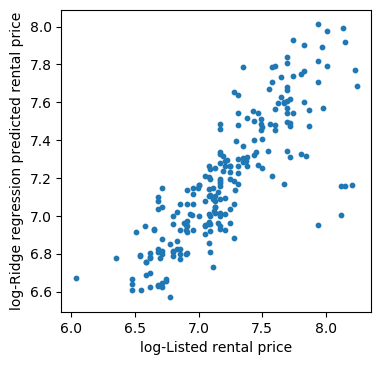

In [130]:
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test,y_test_pred_ridge, s = 10)
#plt.xlim([0,5000])
#plt.ylim([0,5000])
plt.xlabel('log-Listed rental price')
plt.ylabel('log-Ridge regression predicted rental price')
plt.show()

### 5.2 Nonlinear Models

#### 5.2.1 Tree based model

In [131]:
from sklearn.ensemble import RandomForestRegressor

In [132]:
RF = RandomForestRegressor(n_estimators=30)

In [133]:
RF.fit(X_train, y_train)
y_test_pred_RF = RF.predict(X_test)
y_train_pred_RF = RF.predict(X_train)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_RF)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_RF)))

In sample R^2 is 0.9399762154197608
Out of sample R^2 is 0.5651042759769993


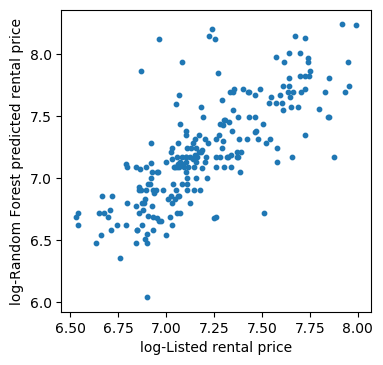

In [134]:
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test_pred_RF, y_test,s=10)
#plt.xlim([0,5000])
#plt.ylim([0,5000])
plt.xlabel('log-Listed rental price')
plt.ylabel('log-Random Forest predicted rental price')
plt.show()

In [407]:
from sklearn.ensemble import GradientBoostingRegressor
GB = GradientBoostingRegressor(max_depth=8)
GB.fit(X_train, y_train)
y_test_pred_GB = GB.predict(X_test)
y_train_pred_GB = GB.predict(X_train)
print('In sample R^2 is {}'.format(metrics.r2_score(y_train, y_train_pred_GB)))
print('Out of sample R^2 is {}'.format(metrics.r2_score(y_test, y_test_pred_GB)))


In sample R^2 is 0.9574897001025985
Out of sample R^2 is 0.6431905025821316


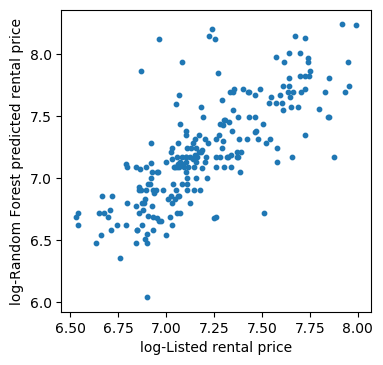

In [408]:
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(y_test_pred_RF, y_test,s=10)
#plt.xlim([0,5000])
#plt.ylim([0,5000])
plt.xlabel('log-Listed rental price')
plt.ylabel('log-Random Forest predicted rental price')
plt.show()

### 5.2.2 K-nearest neighbor

- further feature engineering 
- k-nearest neighbor
- more data will be collected
- fine tuning the models

## 6. Use developed model to predict rental price of for-sale listings


## 6.1 Data Preprocessing

In [425]:
#check null entries, check sale_data types
sale_data.isnull().sum().sum()
sale_data.dtypes

0

In [426]:
# a function to convert the tax assessed values
def conv(x):
    if type(x)==str:
        return float(x.strip('$+').replace(',',''))
    else:
        return x

In [264]:
#get rid of off market, lots, and listings not on market yet
sale_data.drop(sale_data[sale_data['title'].str.contains('Off market')].index,inplace=True)
sale_data.drop(sale_data[sale_data['title'].str.contains('Lot')].index,inplace=True)
sale_data.drop(sale_data[sale_data['title'].str.contains('Coming soon')].index,inplace=True)
sale_data.drop(sale_data[sale_data['home_type'].str.contains('LOT')].index,inplace=True)

#replace 'MANUFACTURED' home type with single family
sale_data['home_type'][sale_data['home_type']=='MANUFACTURED']='SINGLE_FAMILY'

#drop listings without price info
sale_data.drop(sale_data[sale_data['price'].isnull()].index,inplace=True)

#fill in missing bathroom with 1
sale_data['bathroom']=sale_data['bathroom'].fillna(1)

#fill in missing bedroom with 0 (assume studios)
sale_data['bedroom']=sale_data['bedroom'].fillna(0)

#fill missing area with estimations
sale_data['area'].fillna(513+160*sale_data['bedroom']+220*sale_data['bathroom'],inplace=True)

#sale_data['area'].fillna(sale_data['lot_size'],inplace=True)

#tax_assessed_values will be used to estimte property tax
sale_data['tax_assessed_value'].fillna(sale_data['price'],inplace=True)

#drop listings with invalid area after impute
sale_data.drop((sale_data[sale_data['area']==-1]).index,inplace=True)

#convert price into numbers
sale_data['price']=sale_data['price'].apply(lambda x: int(x.strip('$+').replace(',','')) )
sale_data['tax_assessed_value']=sale_data['tax_assessed_value'].apply(lambda x:conv(x))


#get rid of price outliers
sale_data.drop(sale_data[sale_data['price']>1000000].index,inplace=True)
sale_data.drop(sale_data[sale_data['price']<np.quantile(sale_data['price'],0.1)].index,inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


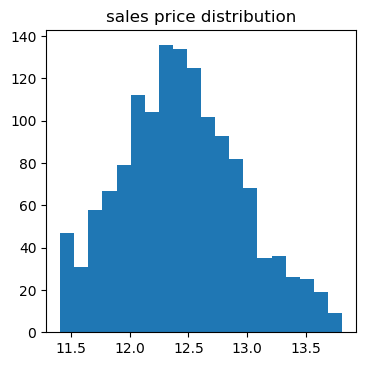

In [428]:
plt.figure(figsize=(4,4), dpi=100)
plt.hist(np.log(sale_data['price'].to_numpy()),20)
#plt.xlim()
plt.title('sales price distribution')
plt.show()

In [269]:
def one_hot_encoding(df, col):
    col_dummy = pd.get_dummies(df[col], drop_first=True)
    df = pd.concat([df, col_dummy], axis=1)
    return df.drop(columns=[col])

In [270]:
# one_hot_encode postal_code and home_type into 
cols = ['postal_code','home_type']
for col in cols:
    sale_data = one_hot_encoding(sale_data, col)

In [271]:
rent_feature_set = set(X_rent.columns)
sale_feature_set = set(X_sale.columns)

In [273]:
X_sale = sale_data[X_rent.columns]

In [429]:
X_sale.head()

,bedroom,bathroom,area,year_built,19103,19104,19106,19107,19111,19114,...,19149,19150,19151,19152,19153,19154,CONDO,MULTI_FAMILY,SINGLE_FAMILY,TOWNHOUSE
1,2.0,2.0,1062.0,1900,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,798.0,1900,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2.0,2.0,1243.0,1900,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,3.0,3.0,1530.0,1850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,2.0,2.0,1111.0,1977,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 6.2 Rental Profit

### Predict rental price

In [275]:
predicted_rent = pd.DataFrame(np.exp(ridge.predict(X_sale)),columns=['predicted_rent'])

In [277]:
sale_data=sale_data.reset_index()

In [314]:
sale_profit_df = pd.concat([sale_data['price'],sale_data['long'],sale_data['bedroom'],sale_data['bathroom'], sale_data['lat'],sale_data['tax_assessed_value'],sale_data['address'], predicted_rent],axis=1)



### Calculate Return on Investment

- ROI is calculated based on rental cash flow with property tax deducted

In [355]:
sale_profit_df['predicted_rent'] = (sale_profit_df['predicted_rent']//100*100).astype(int)

In [357]:
sale_profit_df['property_tax'] = sale_profit_df['tax_assessed_value']*0.01398

In [358]:
sale_profit_df['annual_rent'] = sale_profit_df['predicted_rent']*12

In [359]:
sale_profit_df['annual_cash_flow'] = sale_profit_df['annual_rent']-sale_profit_df['property_tax']

In [360]:
sale_profit_df['ROI'] = sale_profit_df['annual_cash_flow']/sale_profit_df['price']

In [361]:
sale_profit_df = sale_profit_df.sort_values(by='ROI',ascending=False, ignore_index=True)

In [381]:
picked_profit_df = sale_profit_df[sale_profit_df['ROI']<np.quantile(sale_profit_df['ROI'],0.95)]

### Rank of the listings based on ROI

In [383]:
# top 30 profitable listings
picked_profit_df.head()

,price,long,bedroom,bathroom,lat,tax_assessed_value,address,predicted_rent,property_tax,annual_rent,annual_cash_flow,ROI
70,109900,-75.177553,3.0,1.0,40.044594,76600.0,141 E Tulpehocken St,1300,1070.868,15600,14529.132,0.132203
71,95000,-75.149978,3.0,1.0,40.058125,135700.0,6832 Wyncote Ave,1200,1897.086,14400,12502.914,0.131610
72,160000,-75.175297,3.0,2.0,40.005406,44100.0,3237 N Newkirk St,1800,616.518,21600,20983.482,0.131147
73,119900,-75.133306,4.0,2.0,40.029285,78300.0,5112 N Fairhill St,1400,1094.634,16800,15705.366,0.130987
74,115000,-75.230981,3.0,2.0,39.976285,43100.0,1530 N Conestoga St,1300,602.538,15600,14997.462,0.130413


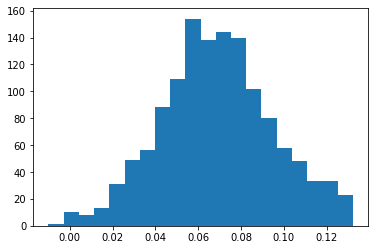

In [387]:
plt.hist(picked_profit_df['ROI'],20)
plt.show()

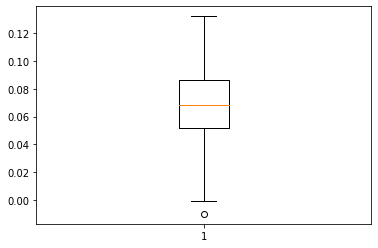

In [389]:
plt.boxplot(picked_profit_df['ROI'])
plt.show()

### Visualize top 50 most profitable listings

In [390]:
import math
from ast import literal_eval
def merc(lon,lat):
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [391]:
mark_data = picked_profit_df.iloc[0:50]

In [392]:
mark_data['coords_x'] = mark_data[['long','lat']].apply(lambda x: merc(*x)[0],axis=1)
mark_data['coords_y'] = mark_data[['long','lat']].apply(lambda x: merc(*x)[1],axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [398]:
picked_profit_df['ROI'].median()

0.06843176441687342

In [396]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import ColumnDataSource, HoverTool

source = ColumnDataSource(data=dict(
                        x=list(mark_data['coords_x']),
                        y=list(mark_data['coords_y']),
                        beds=list(mark_data['bedroom']),
                        baths=list(mark_data['bathroom']),
                        size=list(mark_data['ROI']*100),
                        address=list(mark_data['address']),
                        price=list(mark_data['price']),
                        rent = list(mark_data['predicted_rent']),
                        ROI=list(mark_data['ROI'])))
hover = HoverTool(tooltips=[
        ("beds","@beds"),
        ("baths","@baths"),
        ("price","@price"),
        ("ROI","@ROI"),
        ("rent","@rent"),
        ("address","@address")
])

p = figure(x_axis_type="mercator",
           y_axis_type="mercator",
           tools=[hover, 'wheel_zoom','save','pan'])

p.add_tile(CARTODBPOSITRON)

p.circle(x = 'x',
         y = 'y',
         source=source,
         size = 'size',
         line_color='blue',
         fill_color='navy',
         fill_alpha=0.1)
output_notebook()
show(p)

Loading BokehJS ...

## Final Product

A web application that will tell users:
- Which city has the highest median ROI for rental property investment
- In certain area/city, which listings are the most profitable


## Next steps

- Fine tune the model - combine different modeling appraoch 
- Include forecasting using history data to take appreciation into consideration
- Build web application
